# Recuperação dos nomes dos municípios a partir dos CEPs

* Autoseg: https://www2.susep.gov.br/menuestatistica/Autoseg/principal.aspx
* [Manual da SUSEP](https://www.gov.br/susep/pt-br/servicos/mercado/enviar-dados/arquivos/manual_de_orientacao_para_envio_de_dados_out2023.pdf) (p.81-. Sinistros: p.87-)
* Link para baixar os dados completos: ['AUTO_2021A.rar'](https://www2.susep.gov.br/download/basesdados/scd_auto/AUTO_2021A.rar) (usei o 'S_AUTO_2021A.csv')

Importar pacotes necessários:

In [3]:
import pandas as pd
import numpy as np
from google.colab import drive, files
import os

# gráficos - seaborn e matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.2f}'.format    # pandas: para todos os números aparecerem com duas casas decimais

# Leitura dos microdados

Os dados serão lidos a partir do *google drive*.

In [4]:
# alterar o caminho se necessário, especificando a pasta
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/dados/AUTO_2021A')
# ler o arquivo csv
# o conjunto de dados está com o separador ; e os decimais com ,
df = pd.read_csv('S_AUTO_2021A.csv', sep=';', decimal=',')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-4-a06ec60eebe7>:6: DtypeWarning: Columns (1,9) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('S_AUTO_2021A.csv', sep=';', decimal=',')


# Ajustes nas variáveis

In [5]:
# para visualizar até o número desejado de colunas
pd.set_option('display.max_columns', 24)

# cópia do dataframe
dados = df.copy()
# apagar variáveis
dados = dados.drop(['cod_apo', 'ENDOSSO'], axis=1)
# apagar linha faltante
dados.dropna(inplace=True)

# limpeza da variável 'REGIAO'
# converter todas as ocorrências para número e considerar as não númericas como NaN
dados['REGIAO'] = pd.to_numeric(dados['REGIAO'], errors='coerce')
# transformar NaN em 0
dados['REGIAO'].fillna(0, inplace=True)
# retirar linhas com 'REGIAO' igual a 0 e com 'CEP' igual a 0
dados = dados.drop(dados[(dados['REGIAO'] == 0) & (dados['CEP'] == 0)].index)

# nova coluna 'DATA' pela transformação da data de nascimento no formato correto
dados['DATA'] = pd.to_datetime(dados['D_NASC'], format='%Y%m%d', errors='coerce')
# criar nova coluna 'IDADE' calculada a partir de 'DATA'
now = pd.to_datetime('now', utc=True)
dados['IDADE'] = (now.year - dados['DATA'].dt.year) - ((now.month - dados['DATA'].dt.month) < 0)
# substituir os NaN de IDADE por 'Não informada'
dados['IDADE'] = dados['IDADE'].fillna('Não informada')

<ipython-input-5-1ad81f0b794d>:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados['REGIAO'].fillna(0, inplace=True)


## Substituição de códigos por categorias

In [6]:
# variável 'MODALIDADE'
# criação do dicionário
mod_d = {1: 'VMR',
         2: 'VR',
         3: 'RCF',
         4: 'SP'}
# substituir os códigos pelas descrições usando replace()
dados['MODALIDADE']= dados['MODALIDADE'].replace(mod_d)
# variável 'TIPO_PROD'
# criação do dicionário
prod_d = {1: 'Padrão',
          2: 'Perfil'}
# substituir os códigos pelas descrições usando replace()
dados['TIPO_PROD']= dados['TIPO_PROD'].replace(prod_d)
# variável 'COBERTURA'
cob_d = {1: 'Compreensiva',
         2: 'Incêndio e roubo',
         3: 'Incêndio',
         4: 'Indenização integral, colisão e roubo',
         5: 'Colisão e incêndio',
         9: 'Outros'}
# substituir os códigos pelas descrições usando replace()
dados['COBERTURA']= dados['COBERTURA'].replace(cob_d)
# variável 'COD_MODELO'
# alterar o nome da variável para MODELO
dados.rename(columns={'COD_MODELO': 'MODELO'}, inplace=True)
# carregar a planilha com as codificações dos modelos de automóveis
vei = pd.read_csv('/content/drive/My Drive/dados/Autoseg2021A/auto2_vei.csv', sep=';', encoding='latin1')
# criar o dicionário usando a coluna 'CODIGO' como chave
# e a coluna 'GRUPO' para fazer a substituição
# poderia ser 'DESCRICAO'
vei_d = vei.set_index('CODIGO')['GRUPO'].to_dict()
# substituir os códigos pelas descrições usando map()
# já criando a nova variável
dados['MODELO']= dados['MODELO'].map(vei_d)
# vamos substituir os NaN por 'Outros'
dados['MODELO'] = dados['MODELO'].fillna('OUTROS')
# variável 'REGIAO'
# eu especifiquei as subpastas onde os arquivos se encontram
# dentro do meu google drive: /dados/Autoseg2021A/
reg = pd.read_csv('/content/drive/My Drive/dados/Autoseg2021A/auto_reg.csv', sep=';', encoding='latin1')
# criar o dicionário usando a coluna 'CODIGO' como chave
# e a coluna 'DESCRICAO' para fazer a substituição
reg_d = reg.set_index('CODIGO')['DESCRICAO'].to_dict()
# substituir os códigos pelas descrições
dados['REGIAO'].replace(reg_d, inplace=True)
# variável 'COD_TARIF' (do veículo)
# tirar alguns dos espaços que aparecem antes de alguns códigos
dados['COD_TARIF'] = dados['COD_TARIF'].str.split().str.join(' ')
# retirar o 0 do início de alguns números
dados['COD_TARIF'] = dados['COD_TARIF'].str.replace(r'^0+(\d*)$', r'\1', regex=True)
# substituir os vazios gerados por 0
dados['COD_TARIF'] = dados['COD_TARIF'].replace('', '0')
# criar dicionário
tarif_d = {'10': 'Passeio Nacional',
          '11': 'Passeio Importado',
          '14A': 'Pick-ups leves Nacionais – exceto Kombi e Saveiro',
          '14B':  'Pick-ups leves Nacionais – somente Kombi',
          '14C':  'Pick-ups leves Nacionais – somente Saveiro',
          '15': 'Pick-ups leves Importados',
          '16': 'Modelos esportivos Nacionais',
          '17': 'Modelos esportivos Importados',
          '18': 'Modelos Especiais (Passeio) Nacionais',
          '19': 'Modelos Especiais (Passeio) Importados',
          '20': 'Pick-ups pesadas Carga Nacionais',
          '21': 'Pick-ups pesadas Carga Importados',
          '22': 'Pick-ups pesadas Pessoas Nacionais',
          '23': 'Pick-ups pesadas Pessoas Importado',
          '30': 'Bicicletas Motorizadas, Motocicletas, Motonetas com Reboque ou SIDE-CAR, VESPACAR Nacionais',
          '31': 'Bicicletas Motorizadas, Motocicletas, Motonetas com Reboque ou SIDE-CAR, VESPACAR Importados',
          '40': 'Caminhões Leves Nacionais (até 6,9 ton)',
          '41': 'Caminhões Leves Importados (até 6,9 ton)',
          '42': 'Caminhões Pesados Nacionais (acima de 7 ton – inclusive)',
          '43': 'Caminhões Pesados Importados (acima de 7 ton – inclusive)',
          '50': 'Rebocadores Nacionais',
          '51': 'Rebocadores Importados',
          '52': 'Reboques e Semi-Reboques Nacionais',
          '53': 'Reboques e Semi-Reboques Importados',
          '58': 'Ônibus e Microônibus com Cobrança de Frete Nacionais (exceto urbano com linha regular)',
          '59': 'Ônibus e Microônibus com Cobrança de Frete Importados (exceto urbano com linha regular)',
          '60': 'Ônibus e Microônibus com Cobrança de Frete Nacionais ( urbano com linha regular)',
          '61': 'Ônibus e Microônibus com Cobrança de Frete Importados (urbano com linha regular)',
          '62': 'Ônibus e Microônibus sem Cobrança de Frete Nacionais',
          '63': 'Ônibus e Microônibus sem Cobrança de Frete Importados',
          '68': 'Tratores e Máquinas de Uso Urbano Nacionais',
          '69': 'Tratores e Máquinas de Uso Urbano Importados',
          '70': 'Tratores e Máquinas de Uso Rural Nacionais',
          '71': 'Tratores e Máquinas de Uso Rural Importados',
          '72': 'Guinchos Nacionais (carro socorro)',
          '73': 'Guinchos Importados (carro socorro)',
          '80': 'Táxi Nacionais',
          '81': 'Táxi Importados',
          '82': 'Lotação, Transporte Solidário Nacionais',
          '83': 'Lotação, Transporte Solidário Importados',
          '84': 'Veículo Escolar Nacional (transporte escolar)',
          '85': 'Veículo Escolar Importado (transporte escolar)',
          '86': 'Viagem de Entrega dentro do Território Nacional – Nacional',
          '87': 'Viagem de Entrega dentro do Território Nacional – Importado',
          '88': 'Viagem de Entrega Exclusivamente para Países da América do Sul – Nacional',
          '89': 'Viagem de Entrega Exclusivamente para Países da América do Sul – Importado',
          '90': 'Locadoras Nacionais',
          '91': 'Locadoras Importados',
          '92': 'Veículos Funerários Nacionais',
          '93': 'Veículos Funerários Importados',
          '94': 'Ambulância',
          '95': 'Auto-Escolas',
          '96': 'Bombeiros',
          '97': 'Policiamento'}
# alterar o nome da variável para CATEGORIA
dados.rename(columns={'COD_TARIF': 'CATEGORIA'}, inplace=True)
# usar a função map() para efetuar as substituições
dados['CATEGORIA'] = dados['CATEGORIA'].map(tarif_d)
# substiutir NaNs gerados pela função map() por 'Outros'
dados['CATEGORIA'] = dados['CATEGORIA'].fillna('Outros')
# variável 'COD_CONT'
# alterar o nome da variável para CONTRATO
dados.rename(columns={'COD_CONT': 'CONTRATO'}, inplace=True)
# criação do dicionário
cont_d = {1: 'VMR',
         2: 'VD'}
# substituir os códigos pelas descrições usando replace()
dados['CONTRATO']= dados['CONTRATO'].replace(cont_d)
# variável 'EVENTO'
# criação do dicionário
eve_d = {0: 'Não informado',
         1: 'Casco',
         2: 'Veículos - Danos Materiais',
         3: 'Veículos - Danos Corporais',
         4: 'Veículos - Danos Morais',
         5: 'Passageiros - Morte Acidental',
         6: 'Passageiros - Invalidez Permanente por Acidente',
         7: 'Passageiros - Despesas Médico Hospitalares',
         8: 'Outros'}
# substituir os códigos pelas descrições usando replace()
dados['EVENTO']= dados['EVENTO'].replace(eve_d)
# variável 'CAUSA' (geradora do sinistro)
# criação do dicionário
causa_d = {1: 'Roubo/Furto',
           2: 'Roubo',
           3: 'Furto',
           4: 'Colisão parcial',
           5: 'Colisão Indenização Integral',
           6: 'Incêndio',
           7: 'Assistência 24 horas',
           8: 'Outros',    # código 8 não está descrito no manual (só há uma ocorrência)
           9: 'Outros'}
# substituir os códigos pelas descrições usando replace()
dados['CAUSA']= dados['CAUSA'].replace(causa_d)

<ipython-input-6-e2975cbcbe6b>:46: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dados['REGIAO'].replace(reg_d, inplace=True)


In [7]:
dados.columns

Index(['ITEM', 'MODALIDADE', 'TIPO_PROD', 'COBERTURA', 'MODELO', 'ANO_MODELO',
       'CATEGORIA', 'REGIAO', 'CONTRATO', 'EVENTO', 'INDENIZ', 'VAL_SALVAD',
       'D_SALVADO', 'VAL_RESS', 'D_RESS', 'D_AVI', 'D_LIQ', 'D_OCORR', 'CAUSA',
       'SEXO', 'D_NASC', 'CEP', 'DATA', 'IDADE'],
      dtype='object')

In [8]:
dados.shape

(3747009, 24)

In [9]:
# dados.sample(10)

Variáveis:

* Quantitativas: 'ANO_MODELO', 'INDENIZ', 'VAL_SALVAD', 'IDADE'
* Qualitativas: 'MODALIDADE', 'TIPO_PROD', 'COBERTURA', 'MODELO', 'CATEGORIA', 'REGIAO', 'CONTRATO', 'EVENTO', 'CAUSA', 'SEXO'

## Mais limpezas

Ficaram ainda alguns problemas com os valores que teremos que lidar para gerar os gráficos. Para isso, vamos fazer uma cópia do dataframe 'dados' e realizar algumas modificações que vão nos auxiliar. Alguns problemas:

* Valores de indenizacão negativos;
* Algumas ocorrências de idade faltantes (que substituímos por 'Não informada');
* Ano do modelo do veículo iguais a 0;
* Sexo igual a 0 (sem informação);
* Valor salvado negativo (os que forem iguais a 0 vamos manter, pois há sinistros sem valor salvado).

Valor salvado: valor de um automóvel cujo sinistro foi regularizado como perda total e ainda tenha algum valor de mercado (seja para reparação ou para fornecimento de peças).

In [10]:
df1 = dados.copy()
# variável 'IDADE'
df1['IDADE'] = df1['IDADE'].replace({'Não informada': 0})
# idade entre 18 e 100, ano do veículo > 0,
# indenização >= 0, sexo diferente de 0,
# valor salvado >= 0
df1 = df1.query('IDADE > 18 & IDADE < 100 & ANO_MODELO > 0 & INDENIZ >= 0 & SEXO != "0" & VAL_SALVAD >= 0')

<ipython-input-10-7727c298d396>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df1['IDADE'] = df1['IDADE'].replace({'Não informada': 0})


In [11]:
df1.shape

(3171398, 24)

In [12]:
# resumo estatístico das variáveis categóricas
df1.describe(include='object')

,MODALIDADE,TIPO_PROD,COBERTURA,MODELO,CATEGORIA,REGIAO,CONTRATO,EVENTO,CAUSA,SEXO
count,3171398,3171398,3171398,3171398,3171398,3171398,3171398,3171398,3171398,3171398
unique,4,2,6,444,45,43,2,9,8,2
top,VMR,Perfil,Compreensiva,HYUNDAI HB20,Passeio Nacional,SP - Met. de São Paulo,VMR,Casco,Assistência 24 horas,M
freq,3150301,1752604,3071670,128772,2252059,888308,3159132,1535710,1178958,1719682


Como um CEP válido é composto por 8 dígitos, vamos selecionar apenas as linhas com essa característica.

In [13]:
# criar uma variável num_dig que conta o número de dígitos do CEP
# um CEP válido contém 8 dígitos
df1['num_dig'] = df1['CEP'].apply(lambda x : len(str(x)))

In [14]:
# selecionar as linhas de df1 com CEPs válidos
df1 = df1[df1['num_dig'] == 8]

In [15]:
df1.shape

(2084891, 25)

# Lista de CEPs (outro *dataframe*)

Planilha do Kaggle com CEPs: https://www.kaggle.com/datasets/arvati/lista-de-ceps-do-brasil?resource=download

Um CEP válido é composto por 8 dígitos.

In [16]:
# kaggle: o conjunto de dados está em formato xlsx
cep = pd.read_excel('/content/drive/My Drive/dados/CEP/Lista_de_CEPs.xlsx')

In [17]:
# cep

# Definir uma região (dentre as disponíveis nos dados)

Vamos selecionar apenas uma região para que a busca por CEPs fique mais rápida.

In [18]:
df1['REGIAO'].unique()

array(['SP - Vale do Paraíba e Ribeira', 'RJ - Met. do Rio de Janeiro',
       'PA - Pará', 'SP - Ribeirão Preto e Demais Mun. de Campinas',
       'MG - Met.BH-Centro Oeste-Zona Mata-C. Vertentes', 'BA - Bahia',
       'ES - Espírito Santo', 'RS - Met. Porto Alegre e Caxias do Sul',
       'SP - Met. de São Paulo', 'MG - Sul', 'MG - Triângulo mineiro',
       'PR - Met. Curitiba', 'SC - Blumenau e demais regiões',
       'SC - Oeste', 'MS - Mato Grosso do Sul', 'MT - Mato Grosso',
       'PE - Pernambuco', 'MG - Vale do Aço-Norte-Vale Jequitinhonha',
       'PB - Paraíba', 'RS - Demais regiões', 'PR - Demais regiões',
       'GO - Goiás', 'CE - Ceará', 'DF - Brasília', 'PI - Piaui',
       'AL - Alagoas', 'MA - Maranhão', 'SP - Grande Campinas', 99.0,
       'RJ - Interior', 'SC - Met. Florianópolis e Sul', 'SE - Sergipe',
       'AM - Amazonas', 'PR - F.Iguaþu-Medianeira-Cascavel-Toledo',
       'SP - Litoral Norte e Baixada Santista', 'GO - Sudeste de Goiás',
       'TO - Tocantins'

In [19]:
# número de sinistros por região
df1['REGIAO'].value_counts()

,count
REGIAO,
SP - Ribeirão Preto e Demais Mun. de Campinas,300664
RJ - Met. do Rio de Janeiro,153766
MG - Met.BH-Centro Oeste-Zona Mata-C. Vertentes,126946
BA - Bahia,119578
SP - Grande Campinas,101482
PR - Met. Curitiba,93226
RS - Met. Porto Alegre e Caxias do Sul,89808
RS - Demais regiões,84049
PE - Pernambuco,66630


In [20]:
# sinistros de apenas uma região
df2 = df1.query('REGIAO == "MG - Sul"')
df2 = df2.reset_index(drop=True)

In [21]:
df2.shape

(37326, 25)

In [22]:
# inserindo None nos campos que receberão nomes dos municípios e estados
df2['nome_mun'] = None
df2['sigla_uf'] = None

In [23]:
# inviável
# usando for

# for i in range(len(df2)):
#   # se for um CEP válido (8 dígitos)
#   if df2['num_dig'][i] == 8:
#     # procurar a qual município e UF ele pertence
#     for j in range(len(cep)):
#       if df2['CEP'][i] >= cep['CEP Inicial'][j] and df2['CEP'][i] <= cep['CEP Final'][j]:
#         df2['nome_mun'][i] = cep['Localidade'][j]
#         df2['sigla_uf'][i] = cep['Estado'][j]

In [24]:
# inviável
# usando while

# for i in range(len(df2)):
#   # procurar a qual município e UF ele pertence
#   achou = False
#   j = 0
#   while achou == False and j != len(cep):
#     if df2['CEP'][i] >= cep['CEP Inicial'][j] and df2['CEP'][i] <= cep['CEP Final'][j]:
#       df2.loc[i, ['nome_mun']] = cep['Localidade'][j]
#       df2.loc[i, ['sigla_uf']] = cep['Estado'][j]
#       achou = True
#     j = j + 1

In [25]:
# usando função para descobrir a qual município o CEP pertence

# função para encontrar o nome do município e estado no dataframe cep
# a partir do CEP do dataframe df2
def encontra_cep(linha):
    cep_linha = linha['CEP']
    cep_encontrado = cep[(cep_linha >= cep['CEP Inicial']) & (cep_linha <= cep['CEP Final'])]
    if not cep_encontrado.empty:
        return pd.Series({'sigla_uf': cep_encontrado['Estado'].values[0], 'nome_mun': cep_encontrado['Localidade'].values[0]})
    else:
        return pd.Series({'sigla_uf': None, 'nome_mun': None})

In [26]:
# aplicar a função à coluna CEP de df2
# com apply
df2[['sigla_uf', 'nome_mun']] = df2.apply(encontra_cep, axis=1)

In [27]:
# nomes dos municípios que foram identificados
df2['nome_mun'].value_counts()

,count
nome_mun,
Varginha,2858
Poços de Caldas,2282
Pouso Alegre,1620
Juiz de Fora,1296
Divinópolis,1201
...,...
Pirapetinga,1
São José da Bela Vista,1
Dom Cavati,1


In [28]:
# estados que foram identificados - deveriam ser apenas de MG
df2['sigla_uf'].value_counts()

,count
sigla_uf,
MG,34104
SP,460
RJ,173
ES,37
PR,32
GO,23
BA,14
PE,13
SE,10


In [29]:
df2.sample(10)

,ITEM,MODALIDADE,TIPO_PROD,COBERTURA,MODELO,ANO_MODELO,CATEGORIA,REGIAO,CONTRATO,EVENTO,INDENIZ,VAL_SALVAD,...,D_AVI,D_LIQ,D_OCORR,CAUSA,SEXO,D_NASC,CEP,DATA,IDADE,num_dig,nome_mun,sigla_uf
31759,1,VMR,Perfil,Compreensiva,JEEP-COMPASS,2019,Pick-ups pesadas Pessoas Nacionais,MG - Sul,VMR,Casco,1719.00,0.00,...,20200721,0,20200717,Outros,F,19740712,35590000,1974-07-12,50.00,8,Lagoa da Prata,MG
33381,1,VMR,Perfil,Compreensiva,TOYOTA COROLLA,2019,Passeio Nacional,MG - Sul,VMR,Casco,15141.00,0.00,...,20201222,20210125,20201220,Colisão parcial,M,19771113,37031053,1977-11-13,47.00,8,Varginha,MG
30024,1,VMR,Perfil,Compreensiva,VW VOLKSWAGEN GOL ACIMA DE 1.0,2014,Passeio Nacional,MG - Sul,VMR,Casco,204.00,0.00,...,20201103,0,20201031,Outros,M,19861030,35534000,1986-10-30,38.00,8,Carmópolis de Minas,MG
5648,0,VMR,Padrão,Compreensiva,GM CHEVROLET CRUZE,2013,Passeio Nacional,MG - Sul,VMR,Outros,136.00,0.00,...,20201216,20210113,20201215,Assistência 24 horas,F,19680311,37640000,1968-03-11,57.00,8,Extrema,MG
33807,1,VMR,Perfil,Compreensiva,FORD KA ACIMA DE 1.0,2017,Passeio Nacional,MG - Sul,VMR,Casco,6328.00,0.00,...,20200813,20201224,20200811,Colisão parcial,F,19801219,37940000,1980-12-19,44.00,8,Alpinópolis,MG
1269,1,VMR,Perfil,Compreensiva,RENAULT DUSTER,2012,Passeio Nacional,MG - Sul,VMR,Casco,1951.00,0.00,...,20200817,0,20200816,Colisão parcial,F,19521008,37795000,1952-10-08,72.00,8,Andradas,MG
6981,0,VMR,Perfil,Compreensiva,TOYOTA HILUX,2014,Pick-ups pesadas Carga Importados,MG - Sul,VMR,Casco,519.00,0.00,...,20200722,0,20200722,Roubo,F,19810116,37550000,1981-01-16,44.00,8,None,None
23902,0,VMR,Padrão,Compreensiva,FIAT TORO,2018,Pick-ups pesadas Pessoas Nacionais,MG - Sul,VMR,Outros,97.00,0.00,...,20201106,20201120,20201105,Assistência 24 horas,F,19810319,37551204,1981-03-19,44.00,8,Pouso Alegre,MG
17531,0,VMR,Padrão,Compreensiva,FIAT PALIO WEEKEND,2005,Passeio Nacional,MG - Sul,VMR,Outros,153.00,0.00,...,20200821,20200914,20200820,Assistência 24 horas,M,19350706,36772022,1935-07-06,89.00,8,Cataguases,MG
17168,1,VMR,Perfil,Compreensiva,HONDA CITY,2017,Passeio Nacional,MG - Sul,VMR,Casco,1072.00,0.00,...,20201207,20210118,20201205,Colisão parcial,F,19820422,37704297,1982-04-22,43.00,8,Poços de Caldas,MG


In [30]:
# visualizar os municípios da região 'MG - Sul' que foram classificados como SP
# df2.query('sigla_uf == "SP"')

# Resumos por meio de *groupby* e gráficos

Quais os municípios tiveram mais ocorrências de sinistros em 2020?

In [31]:
# frequência de sinistros nos municípios em ordem decrescente
df2['nome_mun'].value_counts()

,count
nome_mun,
Varginha,2858
Poços de Caldas,2282
Pouso Alegre,1620
Juiz de Fora,1296
Divinópolis,1201
...,...
Pirapetinga,1
São José da Bela Vista,1
Dom Cavati,1


Quais os 10 municípios com mais ocorrências de sinistros em 2020? Fazer um gráfico de colunas.

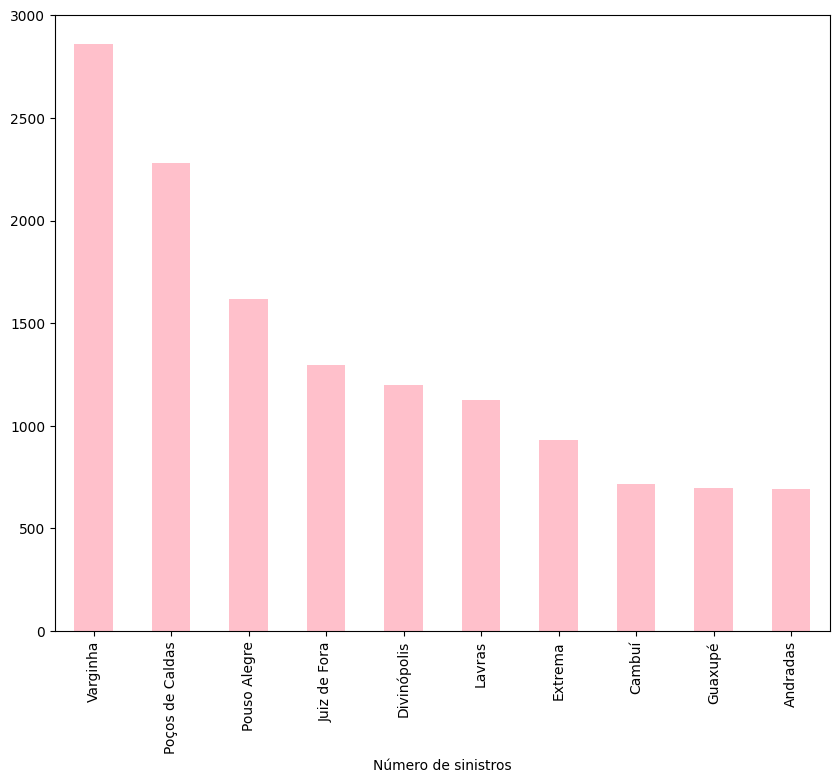

In [32]:
ax = df2['nome_mun'].value_counts().head(10).plot(kind='bar',figsize=(10,8), title='', color='pink')
ax.set_xlabel('Número de sinistros')
plt.show()

Quais as médias das variáveis numéricas por município?

In [33]:
# agrupar as observações por município e obter as médias das outras variáveis
df2.groupby('nome_mun')[['ANO_MODELO', 'INDENIZ', 'VAL_SALVAD', 'VAL_RESS', 'IDADE']].mean()

,ANO_MODELO,INDENIZ,VAL_SALVAD,VAL_RESS,IDADE
nome_mun,,,,,
Abaeté,2012.49,4059.11,1110.46,0.00,52.35
Abre Campo,2014.00,4594.50,0.00,0.00,36.00
Acaiaca,2009.67,471.67,0.00,0.00,58.00
Aguanil,2012.53,4246.47,484.21,0.00,53.16
Aguaí,2012.00,276.00,6100.00,0.00,51.00
...,...,...,...,...,...
Várzea da Palma,2009.00,554.50,0.00,0.00,47.00
Wenceslau Braz,2012.00,79.50,0.00,0.00,52.00
Água Comprida,2020.00,107.00,0.00,0.00,63.00


Quais as médias das variáveis por município, mas ordenadas da maior para a menor média de indenização?

In [34]:
# agrupar por município e ordenar pela indenização em ordem decrescente
df2.groupby('nome_mun')[['ANO_MODELO', 'INDENIZ', 'VAL_SALVAD', 'VAL_RESS', 'IDADE']].mean().sort_values(by='INDENIZ', ascending=False)

,ANO_MODELO,INDENIZ,VAL_SALVAD,VAL_RESS,IDADE
nome_mun,,,,,
Aimorés,2013.00,128533.00,43025.00,0.00,48.00
Piraí,2019.00,86153.00,0.00,0.00,44.00
Bias Fortes,2012.50,79964.00,40250.00,0.00,40.00
São Domingos do Prata,2011.00,66946.00,30795.00,0.00,42.00
Patrocínio,2015.00,51906.00,22931.00,0.00,46.00
...,...,...,...,...,...
Wenceslau Braz,2012.00,79.50,0.00,0.00,52.00
Araruama,2008.00,68.00,0.00,0.00,65.00
Pinhalzinho,2015.00,66.00,0.00,0.00,71.00


Quais as médias das variáveis por município e as frequências de sinistros por município?

In [35]:
# agrupar por município e mostrar média e frequência das variáveis escolhidas
(df2.groupby('nome_mun')[['ANO_MODELO', 'INDENIZ', 'VAL_SALVAD', 'VAL_RESS', 'IDADE']].
            agg([('média','mean'),('freq','count')]).reset_index())

nome_mun ANO_MODELO      INDENIZ      VAL_SALVAD      VAL_RESS  \
                          média freq   média freq      média freq    média   
0             Abaeté    2012.49   83 4059.11   83    1110.46   83     0.00   
1         Abre Campo    2014.00    2 4594.50    2       0.00    2     0.00   
2            Acaiaca    2009.67    3  471.67    3       0.00    3     0.00   
3            Aguanil    2012.53   19 4246.47   19     484.21   19     0.00   
4              Aguaí    2012.00    2  276.00    2    6100.00    2     0.00   
..               ...        ...  ...     ...  ...        ...  ...      ...   
601  Várzea da Palma    2009.00    2  554.50    2       0.00    2     0.00   
602   Wenceslau Braz    2012.00    2   79.50    2       0.00    2     0.00   
603    Água Comprida    2020.00    1  107.00    1       0.00    1     0.00   
604   Águas da Prata    2015.75    4  621.00    4       0.00    4     0.00   
605  Álvares Machado    2013.00    2   94.50    2       0.00    2     0.00   

         IDADE       
    freq média freq  
0     83 52.35   83  
1      2 36.00    2  
2      3 58.00    3  
3     19 53.16   19  
4      2 51.00    2  
..   ...   ...  ...  
601    2 47.00    2  
602    2 52.00    2  
603    1 63.00    1  
604    4 42.75    4  
605    2 48.00    2  

[606 rows x 11 columns]

Para um município específico (ou mais de um): quais as médias das variáveis e a frequência de sinistros?

In [36]:
# agrupar por município e mostrar média e frequência das variáveis escolhidas
# identificando um município
d = df2.groupby('nome_mun')[['ANO_MODELO', 'INDENIZ', 'VAL_SALVAD', 'VAL_RESS', 'IDADE']].agg([('média','mean'),('freq','count')])
d.query("nome_mun == ['Varginha', 'Lavras', 'Três Pontas']")

ANO_MODELO       INDENIZ       VAL_SALVAD       VAL_RESS        \
                 média  freq   média  freq      média  freq    média  freq   
nome_mun                                                                     
Lavras         2014.32  1128 1942.53  1128     310.53  1128     7.82  1128   
Três Pontas    2013.57   629 3712.57   629     434.47   629     0.00   629   
Varginha       2013.83  2858 2607.96  2858     140.18  2858     0.05  2858   

            IDADE        
            média  freq  
nome_mun                 
Lavras      50.90  1128  
Três Pontas 53.50   629  
Varginha    49.72  2858

Quais as médias das variáveis por tipo de evento de sinistro e as frequências de sinistros?

In [37]:
# agrupar por evento e mostrar média e frequência das variáveis escolhidas
(df2.groupby(['EVENTO'])[['ANO_MODELO', 'INDENIZ', 'VAL_SALVAD', 'VAL_RESS', 'IDADE']]
     .agg([('média','mean'),('freq','count')])
     .reset_index())

EVENTO ANO_MODELO         INDENIZ  \
                                                        média   freq    média   
0                                            Casco    2013.31  22709  3634.50   
1                                           Outros    2013.28  11432   373.09   
2       Passageiros - Despesas Médico Hospitalares    2013.00      1 10000.00   
3  Passageiros - Invalidez Permanente por Acidente    2015.00      1 22900.00   
4                    Passageiros - Morte Acidental    2013.29      7 11166.43   
5                       Veículos - Danos Corporais    2012.44     32 18196.19   
6                       Veículos - Danos Materiais    2013.68   3144  5511.57   

         VAL_SALVAD        VAL_RESS        IDADE         
    freq      média   freq    média   freq média   freq  
0  22709     459.26  22709    12.95  22709 50.43  22709  
1  11432     216.34  11432     0.00  11432 55.47  11432  
2      1       0.00      1     0.00      1 42.00      1  
3      1       0.00      1     0.00      1 32.00      1  
4      7       0.00      7     0.00      7 46.29      7  
5     32       0.00     32     0.00     32 45.97     32  
6   3144     292.44   3144     0.00   3144 51.17   3144

Fazer um gráfico de colunas com o número de sinistros por tipo de evento.

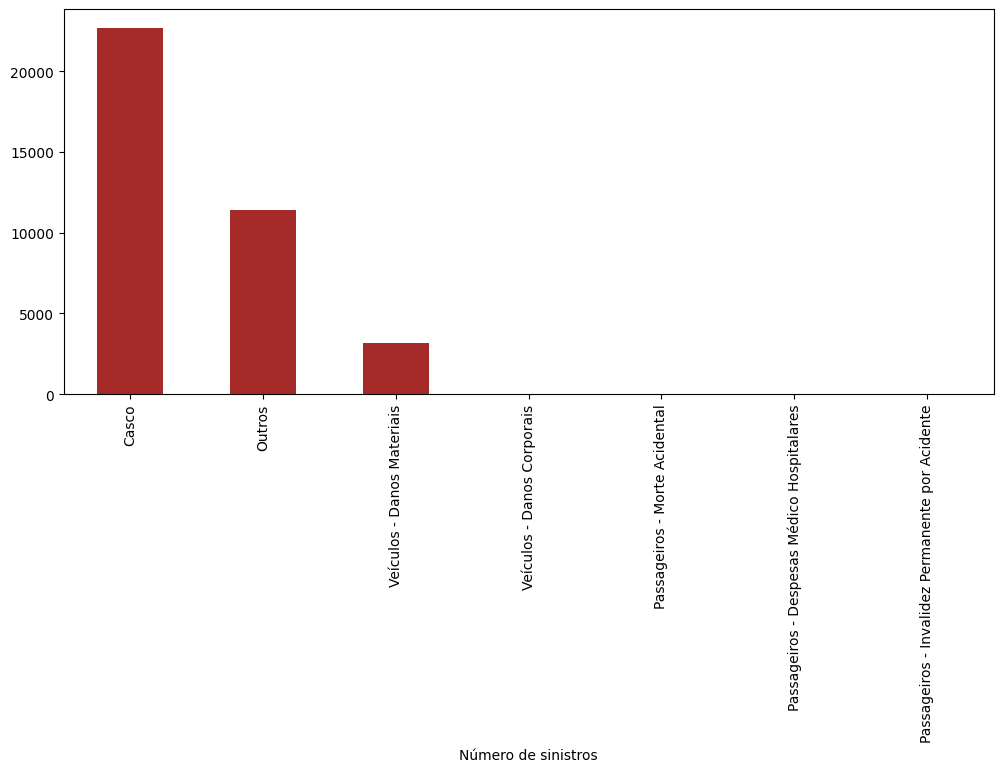

In [38]:
# gráfico de colunas por evento e mostrar número de sinistros
ax = df2.groupby('EVENTO')['INDENIZ'] \
    .agg(['mean', 'count']) \
    .sort_values('count', ascending=False)['count'] \
    .plot(kind='bar', figsize=(12,5), title='', color='brown')
ax.set_xlabel('Número de sinistros')
plt.show()

Fazer um gráfico de colunas com a média de indenizações recebidas por tipo de evento.

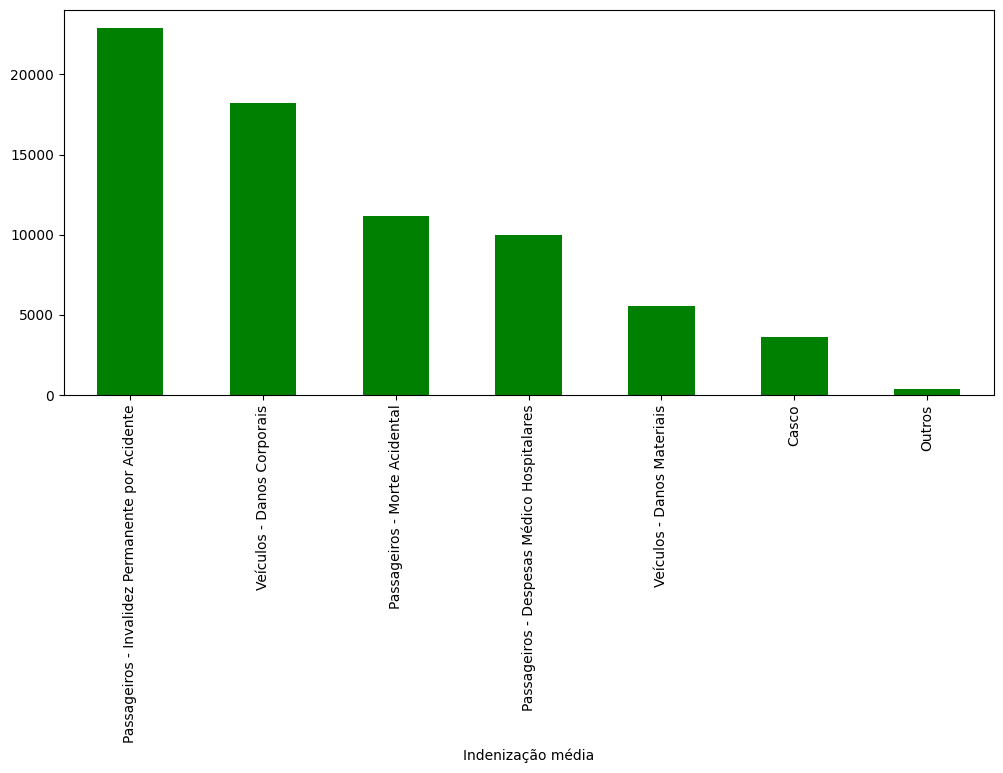

In [39]:
# gráfico de colunas por evento e mostrar média de indenizações
ax = df2.groupby('EVENTO')['INDENIZ'] \
    .agg(['mean', 'count']) \
    .sort_values('mean', ascending=False)['mean'] \
    .plot(kind='bar', figsize=(12,5), title='', color='green')
ax.set_xlabel('Indenização média')
plt.show()

Quais as médias de indenizações, valores salvados, valores ressarcidos e idade por ano?

In [40]:
# agrupar por ANO_MODELO e obter médias das variáveis escolhidas
df2.groupby(['ANO_MODELO'])[['INDENIZ', 'VAL_SALVAD', 'VAL_RESS', 'IDADE']].mean()

,INDENIZ,VAL_SALVAD,VAL_RESS,IDADE
ANO_MODELO,,,,
1970,3556.50,0.00,0.00,44.50
1971,4864.50,0.00,0.00,41.50
1972,5509.00,0.00,0.00,60.00
1974,154.33,0.00,0.00,59.33
1975,2010.00,0.00,0.00,55.00
1977,4171.00,0.00,0.00,51.50
1978,2100.00,0.00,0.00,81.00
1980,3769.83,0.00,0.00,47.67
1981,4425.00,0.00,0.00,55.00


Quais as médias de indenizações, valores salvados, valores ressarcidos e idade por ano, ordenando pelo ano com maior média de indenização?

In [41]:
# agrupar por ANO_MODELO e ordenar pela indenização em ordem decrescente
df2.groupby('ANO_MODELO')[['INDENIZ', 'VAL_SALVAD', 'VAL_RESS', 'IDADE']].mean().sort_values(by='INDENIZ', ascending=False)

,INDENIZ,VAL_SALVAD,VAL_RESS,IDADE
ANO_MODELO,,,,
1992,12416.00,0.00,0.00,58.50
2021,5738.27,527.60,0.00,51.32
1972,5509.00,0.00,0.00,60.00
1982,4997.50,0.00,0.00,58.50
1971,4864.50,0.00,0.00,41.50
2020,4573.83,397.10,0.19,52.19
1981,4425.00,0.00,0.00,55.00
1977,4171.00,0.00,0.00,51.50
1980,3769.83,0.00,0.00,47.67


Quais as médias de indenizações, valores salvados, valores ressarcidos e idade por ano, ordenando pelo ano com maior média de indenização? Mostrar os 10 primeiros.

In [42]:
 # agrupar por ANO_MODELO e ordenar pela indenização em ordem decrescente
df2.groupby('ANO_MODELO')[['INDENIZ', 'VAL_SALVAD', 'VAL_RESS', 'IDADE']].mean().sort_values(by='INDENIZ', ascending=False).head(10)

,INDENIZ,VAL_SALVAD,VAL_RESS,IDADE
ANO_MODELO,,,,
1992,12416.00,0.00,0.00,58.50
2021,5738.27,527.60,0.00,51.32
1972,5509.00,0.00,0.00,60.00
1982,4997.50,0.00,0.00,58.50
1971,4864.50,0.00,0.00,41.50
2020,4573.83,397.10,0.19,52.19
1981,4425.00,0.00,0.00,55.00
1977,4171.00,0.00,0.00,51.50
1980,3769.83,0.00,0.00,47.67
